In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from einops import rearrange
from tqdm import tqdm
from pytorch_msssim import ssim
from torchsummary import summary

C:\Users\uceti\anaconda3\envs\CUDA-pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange

class EfficientAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=8, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.qkv_proj = nn.Linear(embed_dim, embed_dim * 3)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = self.head_dim ** -0.5

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv_proj(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.num_heads), qkv)
        k = k.softmax(dim=-2)
        context = torch.einsum('bhnd,bhne->bhde', k, v)
        attn = torch.einsum('bhnd,bhde->bhne', q, context) * self.scale
        out = rearrange(attn, 'b h n d -> b n (h d)')
        out = self.out_proj(out)
        return self.dropout(out)

class EnhancedPatchEmbedding(nn.Module):
    def __init__(self, img_size=256, patch_size=16, in_channels=3, embed_dim=512):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Conv2d(in_channels, embed_dim // 2, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(embed_dim // 2),
            nn.GELU(),
            nn.Conv2d(embed_dim // 2, embed_dim, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(embed_dim),
            nn.GELU(),
            nn.Conv2d(embed_dim, embed_dim, kernel_size=patch_size // 2, stride=patch_size // 2, padding=0),
            nn.BatchNorm2d(embed_dim)
        )

    def forward(self, x):
        x = self.proj(x)
        return rearrange(x, 'b c h w -> b (h w) c')


class EnhancedTransformerEncoder(nn.Module):
    def __init__(self, embed_dim=512, num_heads=8, num_layers=4, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.ModuleDict({
                'norm1': nn.LayerNorm(embed_dim),
                'attn': EfficientAttention(embed_dim, num_heads, dropout),
                'norm2': nn.LayerNorm(embed_dim),
                'mlp': nn.Sequential(
                    nn.Linear(embed_dim, embed_dim * 4),
                    nn.GELU(),
                    nn.Dropout(dropout),
                    nn.Linear(embed_dim * 4, embed_dim),
                    nn.Dropout(dropout)
                )
            }) for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        skip_connections = []
        for layer in self.layers:
            x_norm = layer['norm1'](x)
            x = x + layer['attn'](x_norm)
            x_norm = layer['norm2'](x)
            x = x + layer['mlp'](x_norm)
            skip_connections.append(x)
        return self.norm(x), skip_connections

class FeatureAlignmentModule(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.LayerNorm(out_dim),
            nn.GELU()
        )
        self.spatial_align = nn.Conv2d(1, 1, kernel_size=3, padding=1)

    def forward(self, x, target_size):
        B, N, C = x.shape
        H, W = target_size
        x = self.proj(x)
        x = rearrange(x, 'b (h w) c -> b c h w', h=int(N**0.5))
        x = F.interpolate(x, size=target_size, mode='bilinear', align_corners=False)
        x = x + self.spatial_align(x.mean(dim=1, keepdim=True))
        return x

class EnhancedSSMDecoder(nn.Module):
    def __init__(self, embed_dim=512, out_channels=3):
        super().__init__()
        self.embed_dim = embed_dim
        self.skip_align = nn.ModuleList([
            FeatureAlignmentModule(embed_dim, embed_dim//2),
            FeatureAlignmentModule(embed_dim, embed_dim//4),
            FeatureAlignmentModule(embed_dim, embed_dim//8),
            FeatureAlignmentModule(embed_dim, embed_dim//16)
            #FeatureAlignmentModule(embed_dim, embed_dim//32)
        ])
        self.up_blocks = nn.ModuleList([
            self._make_up_block(embed_dim, embed_dim//2),
            self._make_up_block(embed_dim//2, embed_dim//4),
            self._make_up_block(embed_dim//4, embed_dim//8),
            self._make_up_block(embed_dim//8, embed_dim//16),
            self._make_up_block(embed_dim//16, embed_dim//32),
            self._make_up_block(embed_dim // 32, embed_dim // 64)
        ])
        self.final_conv = nn.Sequential(
            nn.Conv2d(embed_dim // 16, embed_dim // 16, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(embed_dim // 16, out_channels, kernel_size=1)
        )
    def _make_up_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch * 4, kernel_size=3, padding=1),
            nn.PixelShuffle(2),
            nn.BatchNorm2d(out_ch),
            nn.GELU(),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.GELU()
        )


    def forward(self, x, skip_connections):
        B, N, C = x.shape
        x = rearrange(x, 'b (h w) c -> b c h w', h=int(N**0.5))
        for i, (up_block, skip_align) in enumerate(zip(self.up_blocks, self.skip_align)):
            x = up_block(x)
            skip_idx = min(len(skip_connections) - 1, i)
            skip = skip_align(skip_connections[-(skip_idx + 1)], x.shape[-2:])
            x = x + skip
        return torch.sigmoid(self.final_conv(x))

class EnhancedHybridMamba(nn.Module):
    def __init__(self, img_size=256, patch_size=16, in_channels=3, embed_dim=512):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.patch_embed = EnhancedPatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.transformer = EnhancedTransformerEncoder(embed_dim, num_layers=4)
        self.decoder = EnhancedSSMDecoder(embed_dim)        
       
        self.final_upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  
            nn.Conv2d(3, 3, kernel_size=3, padding=1),  
            nn.Sigmoid()  
        )

    def forward(self, x):
        x = self.patch_embed(x)
        x, skip_connections = self.transformer(x)
        x = self.decoder(x, skip_connections)
        x = self.final_upsample(x)
        return x

In [3]:
model = EnhancedHybridMamba(img_size=256)
input_tensor = torch.randn(1, 3, 256, 256) 
output = model(input_tensor)
print(output.shape) 

torch.Size([1, 3, 256, 256])


In [4]:
##Training and vlaidation

In [5]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
import json


In [6]:
def get_dataloaders(data_dir, batch_size=8, img_size=256, num_workers=4):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()
    ])

    train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
    val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader


In [ ]:
## Composite Loss function

In [7]:
import torch
import torch.nn.functional as F
from pytorch_msssim import ssim

def mse_loss(pred, target):
    return F.mse_loss(pred, target)

def ssim_loss(pred, target):
    return 1 - ssim(pred, target, data_range=1.0, size_average=True)

def gradient_loss(pred, target):
    def compute_gradient(img):
        dy = torch.abs(img[:, :, 1:, :] - img[:, :, :-1, :])
        dx = torch.abs(img[:, :, :, 1:] - img[:, :, :, :-1])
        return dx, dy

    dx_pred, dy_pred = compute_gradient(pred)
    dx_gt, dy_gt = compute_gradient(target)
    
    grad_diff_x = torch.abs(dx_pred - dx_gt)
    grad_diff_y = torch.abs(dy_pred - dy_gt)
    
    return grad_diff_x.mean() + grad_diff_y.mean()


In [8]:
##Training model

In [9]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_validate_model(model, train_loader, val_loader, epochs=30, lr=1e-4, device='cuda'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    stats = {
        'train_loss': [],
        'val_loss': [],
        'train_mse': [],
        'train_ssim': [],
        'train_grad': [],
    }

    os.makedirs("checkpoints", exist_ok=True)

    for epoch in range(1, epochs + 1):
        model.train()
        running_train_loss = 0.0
        running_mse = 0.0
        running_ssim = 0.0
        running_grad = 0.0

        for images, _ in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} - Training"):
            images = images.to(device)
            outputs = model(images)

            loss_mse = mse_loss(outputs, images)
            loss_ssim = ssim_loss(outputs, images)
            loss_grad = gradient_loss(outputs, images)
            total_loss = loss_mse + 0.85 * loss_ssim + 0.1 * loss_grad

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            batch_size = images.size(0)
            running_train_loss += total_loss.item() * batch_size
            running_mse += loss_mse.item() * batch_size
            running_ssim += loss_ssim.item() * batch_size
            running_grad += loss_grad.item() * batch_size

        num_train = len(train_loader.dataset)
        avg_train_loss = running_train_loss / num_train
        avg_mse = running_mse / num_train
        avg_ssim = running_ssim / num_train
        avg_grad = running_grad / num_train

        stats['train_loss'].append(avg_train_loss)
        stats['train_mse'].append(avg_mse)
        stats['train_ssim'].append(avg_ssim)
        stats['train_grad'].append(avg_grad)

        print(f"\n📘 Epoch [{epoch}/{epochs}]")
        print(f"  Train MSE Loss:    {avg_mse:.6f}")
        print(f"  Train SSIM Loss:   {avg_ssim:.6f}")
        print(f"  Train Grad Loss:   {avg_grad:.6f}")
        print(f"  👉 Total Train Loss:{avg_train_loss:.6f}")

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, _ in tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} - Validating"):
                images = images.to(device)
                outputs = model(images)

                loss_mse = mse_loss(outputs, images)
                loss_ssim = ssim_loss(outputs, images)
                loss_grad = gradient_loss(outputs, images)
                v_loss = loss_mse + 0.85 * loss_ssim + 0.1 * loss_grad
                val_loss += v_loss.item() * images.size(0)

        avg_val_loss = val_loss / len(val_loader.dataset)
        stats['val_loss'].append(avg_val_loss)

        print(f"  ✅ Validation Loss: {avg_val_loss:.6f}")

         if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
            }, 'checkpoints/best_model.pth')
            print("💾 Best model checkpoint saved.")

    with open('checkpoints/training_stats.json', 'w') as f:
        json.dump(stats, f, indent=4)

    with open('checkpoints/loss_details.txt', 'w') as f:
        f.write("Epoch\tTrain_MSE\tTrain_SSIM\tTrain_Grad\tTotal_Train_Loss\tVal_Loss\n")
        for i in range(epochs):
            f.write(f"{i+1}\t{stats['train_mse'][i]:.6f}\t{stats['train_ssim'][i]:.6f}\t{stats['train_grad'][i]:.6f}\t{stats['train_loss'][i]:.6f}\t{stats['val_loss'][i]:.6f}\n")

    print("\n🎉 Training complete. All losses and best model saved.")


In [10]:
# Start training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = EnhancedHybridMamba(img_size=256)

train_loader, val_loader = get_dataloaders(data_dir='dataset', batch_size=4)
train_validate_model(model, train_loader, val_loader, epochs=200, lr=1e-4, device=device)


Epoch 1/200 - Training: 100%|██████████| 1980/1980 [03:15<00:00, 10.12it/s]



📘 Epoch [1/200]
  Train MSE Loss:    0.013419
  Train SSIM Loss:   0.150006
  Train Grad Loss:   0.023089
  👉 Total Train Loss:0.143233


Epoch 1/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.07it/s]


  ✅ Validation Loss: 0.076218
💾 Best model checkpoint saved.


Epoch 2/200 - Training: 100%|██████████| 1980/1980 [03:14<00:00, 10.19it/s]



📘 Epoch [2/200]
  Train MSE Loss:    0.005590
  Train SSIM Loss:   0.069830
  Train Grad Loss:   0.019557
  👉 Total Train Loss:0.066901


Epoch 2/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.00it/s]


  ✅ Validation Loss: 0.052803
💾 Best model checkpoint saved.


Epoch 3/200 - Training: 100%|██████████| 1980/1980 [03:14<00:00, 10.17it/s]



📘 Epoch [3/200]
  Train MSE Loss:    0.003033
  Train SSIM Loss:   0.049862
  Train Grad Loss:   0.017851
  👉 Total Train Loss:0.047201


Epoch 3/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.62it/s]


  ✅ Validation Loss: 0.038258
💾 Best model checkpoint saved.


Epoch 4/200 - Training: 100%|██████████| 1980/1980 [03:15<00:00, 10.12it/s]



📘 Epoch [4/200]
  Train MSE Loss:    0.001616
  Train SSIM Loss:   0.037137
  Train Grad Loss:   0.016316
  👉 Total Train Loss:0.034815


Epoch 4/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.57it/s]


  ✅ Validation Loss: 0.030401
💾 Best model checkpoint saved.


Epoch 5/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.30it/s]



📘 Epoch [5/200]
  Train MSE Loss:    0.000906
  Train SSIM Loss:   0.030307
  Train Grad Loss:   0.015311
  👉 Total Train Loss:0.028198


Epoch 5/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.19it/s]


  ✅ Validation Loss: 0.026411
💾 Best model checkpoint saved.


Epoch 6/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.26it/s]



📘 Epoch [6/200]
  Train MSE Loss:    0.000578
  Train SSIM Loss:   0.026276
  Train Grad Loss:   0.014635
  👉 Total Train Loss:0.024376


Epoch 6/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.77it/s]


  ✅ Validation Loss: 0.023259
💾 Best model checkpoint saved.


Epoch 7/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [7/200]
  Train MSE Loss:    0.000425
  Train SSIM Loss:   0.023616
  Train Grad Loss:   0.014143
  👉 Total Train Loss:0.021914


Epoch 7/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.06it/s]


  ✅ Validation Loss: 0.021661
💾 Best model checkpoint saved.


Epoch 8/200 - Training: 100%|██████████| 1980/1980 [03:14<00:00, 10.19it/s]



📘 Epoch [8/200]
  Train MSE Loss:    0.000348
  Train SSIM Loss:   0.021702
  Train Grad Loss:   0.013760
  👉 Total Train Loss:0.020170


Epoch 8/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.50it/s]


  ✅ Validation Loss: 0.020487
💾 Best model checkpoint saved.


Epoch 9/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [9/200]
  Train MSE Loss:    0.000299
  Train SSIM Loss:   0.020211
  Train Grad Loss:   0.013443
  👉 Total Train Loss:0.018823


Epoch 9/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.41it/s]


  ✅ Validation Loss: 0.019353
💾 Best model checkpoint saved.


Epoch 10/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.25it/s]



📘 Epoch [10/200]
  Train MSE Loss:    0.000268
  Train SSIM Loss:   0.019041
  Train Grad Loss:   0.013179
  👉 Total Train Loss:0.017771


Epoch 10/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.58it/s]


  ✅ Validation Loss: 0.018308
💾 Best model checkpoint saved.


Epoch 11/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.25it/s]



📘 Epoch [11/200]
  Train MSE Loss:    0.000246
  Train SSIM Loss:   0.018075
  Train Grad Loss:   0.012956
  👉 Total Train Loss:0.016906


Epoch 11/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.60it/s]


  ✅ Validation Loss: 0.017970
💾 Best model checkpoint saved.


Epoch 12/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [12/200]
  Train MSE Loss:    0.000228
  Train SSIM Loss:   0.017237
  Train Grad Loss:   0.012759
  👉 Total Train Loss:0.016156


Epoch 12/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.40it/s]


  ✅ Validation Loss: 0.016993
💾 Best model checkpoint saved.


Epoch 13/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [13/200]
  Train MSE Loss:    0.000214
  Train SSIM Loss:   0.016506
  Train Grad Loss:   0.012583
  👉 Total Train Loss:0.015502


Epoch 13/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.07it/s]


  ✅ Validation Loss: 0.016667
💾 Best model checkpoint saved.


Epoch 14/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.24it/s]



📘 Epoch [14/200]
  Train MSE Loss:    0.000203
  Train SSIM Loss:   0.015895
  Train Grad Loss:   0.012430
  👉 Total Train Loss:0.014956


Epoch 14/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.29it/s]


  ✅ Validation Loss: 0.016128
💾 Best model checkpoint saved.


Epoch 15/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.25it/s]



📘 Epoch [15/200]
  Train MSE Loss:    0.000193
  Train SSIM Loss:   0.015380
  Train Grad Loss:   0.012296
  👉 Total Train Loss:0.014495


Epoch 15/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.39it/s]


  ✅ Validation Loss: 0.015699
💾 Best model checkpoint saved.


Epoch 16/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [16/200]
  Train MSE Loss:    0.000183
  Train SSIM Loss:   0.014864
  Train Grad Loss:   0.012166
  👉 Total Train Loss:0.014035


Epoch 16/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 33.88it/s]


  ✅ Validation Loss: 0.015434
💾 Best model checkpoint saved.


Epoch 17/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.26it/s]



📘 Epoch [17/200]
  Train MSE Loss:    0.000177
  Train SSIM Loss:   0.014457
  Train Grad Loss:   0.012054
  👉 Total Train Loss:0.013671


Epoch 17/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.66it/s]


  ✅ Validation Loss: 0.014996
💾 Best model checkpoint saved.


Epoch 18/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [18/200]
  Train MSE Loss:    0.000167
  Train SSIM Loss:   0.014019
  Train Grad Loss:   0.011944
  👉 Total Train Loss:0.013278


Epoch 18/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.56it/s]


  ✅ Validation Loss: 0.014542
💾 Best model checkpoint saved.


Epoch 19/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.26it/s]



📘 Epoch [19/200]
  Train MSE Loss:    0.000158
  Train SSIM Loss:   0.013640
  Train Grad Loss:   0.011843
  👉 Total Train Loss:0.012936


Epoch 19/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.67it/s]


  ✅ Validation Loss: 0.014234
💾 Best model checkpoint saved.


Epoch 20/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [20/200]
  Train MSE Loss:    0.000150
  Train SSIM Loss:   0.013262
  Train Grad Loss:   0.011743
  👉 Total Train Loss:0.012597


Epoch 20/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.36it/s]


  ✅ Validation Loss: 0.014047
💾 Best model checkpoint saved.


Epoch 21/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [21/200]
  Train MSE Loss:    0.000145
  Train SSIM Loss:   0.012943
  Train Grad Loss:   0.011653
  👉 Total Train Loss:0.012312


Epoch 21/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.36it/s]


  ✅ Validation Loss: 0.013525
💾 Best model checkpoint saved.


Epoch 22/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [22/200]
  Train MSE Loss:    0.000139
  Train SSIM Loss:   0.012608
  Train Grad Loss:   0.011562
  👉 Total Train Loss:0.012011


Epoch 22/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.19it/s]


  ✅ Validation Loss: 0.013447
💾 Best model checkpoint saved.


Epoch 23/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.25it/s]



📘 Epoch [23/200]
  Train MSE Loss:    0.000135
  Train SSIM Loss:   0.012345
  Train Grad Loss:   0.011481
  👉 Total Train Loss:0.011777


Epoch 23/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.17it/s]


  ✅ Validation Loss: 0.013302
💾 Best model checkpoint saved.


Epoch 24/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.25it/s]



📘 Epoch [24/200]
  Train MSE Loss:    0.000130
  Train SSIM Loss:   0.012042
  Train Grad Loss:   0.011395
  👉 Total Train Loss:0.011505


Epoch 24/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.83it/s]


  ✅ Validation Loss: 0.013130
💾 Best model checkpoint saved.


Epoch 25/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.29it/s]



📘 Epoch [25/200]
  Train MSE Loss:    0.000126
  Train SSIM Loss:   0.011791
  Train Grad Loss:   0.011316
  👉 Total Train Loss:0.011280


Epoch 25/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.21it/s]


  ✅ Validation Loss: 0.012887
💾 Best model checkpoint saved.


Epoch 26/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.24it/s]



📘 Epoch [26/200]
  Train MSE Loss:    0.000123
  Train SSIM Loss:   0.011561
  Train Grad Loss:   0.011240
  👉 Total Train Loss:0.011074


Epoch 26/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.23it/s]


  ✅ Validation Loss: 0.012512
💾 Best model checkpoint saved.


Epoch 27/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.26it/s]



📘 Epoch [27/200]
  Train MSE Loss:    0.000120
  Train SSIM Loss:   0.011348
  Train Grad Loss:   0.011169
  👉 Total Train Loss:0.010883


Epoch 27/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 33.98it/s]


  ✅ Validation Loss: 0.012375
💾 Best model checkpoint saved.


Epoch 28/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [28/200]
  Train MSE Loss:    0.000117
  Train SSIM Loss:   0.011095
  Train Grad Loss:   0.011090
  👉 Total Train Loss:0.010656


Epoch 28/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.84it/s]


  ✅ Validation Loss: 0.012165
💾 Best model checkpoint saved.


Epoch 29/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [29/200]
  Train MSE Loss:    0.000114
  Train SSIM Loss:   0.010898
  Train Grad Loss:   0.011021
  👉 Total Train Loss:0.010479


Epoch 29/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.34it/s]


  ✅ Validation Loss: 0.011864
💾 Best model checkpoint saved.


Epoch 30/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.30it/s]



📘 Epoch [30/200]
  Train MSE Loss:    0.000111
  Train SSIM Loss:   0.010682
  Train Grad Loss:   0.010949
  👉 Total Train Loss:0.010286


Epoch 30/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.49it/s]


  ✅ Validation Loss: 0.011801
💾 Best model checkpoint saved.


Epoch 31/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.25it/s]



📘 Epoch [31/200]
  Train MSE Loss:    0.000108
  Train SSIM Loss:   0.010490
  Train Grad Loss:   0.010881
  👉 Total Train Loss:0.010113


Epoch 31/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 33.97it/s]


  ✅ Validation Loss: 0.011599
💾 Best model checkpoint saved.


Epoch 32/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.26it/s]



📘 Epoch [32/200]
  Train MSE Loss:    0.000107
  Train SSIM Loss:   0.010319
  Train Grad Loss:   0.010816
  👉 Total Train Loss:0.009959


Epoch 32/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 33.91it/s]


  ✅ Validation Loss: 0.011457
💾 Best model checkpoint saved.


Epoch 33/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [33/200]
  Train MSE Loss:    0.000104
  Train SSIM Loss:   0.010126
  Train Grad Loss:   0.010749
  👉 Total Train Loss:0.009786


Epoch 33/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.58it/s]


  ✅ Validation Loss: 0.011507


Epoch 34/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [34/200]
  Train MSE Loss:    0.000102
  Train SSIM Loss:   0.009968
  Train Grad Loss:   0.010689
  👉 Total Train Loss:0.009644


Epoch 34/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.09it/s]


  ✅ Validation Loss: 0.011191
💾 Best model checkpoint saved.


Epoch 35/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.30it/s]



📘 Epoch [35/200]
  Train MSE Loss:    0.000100
  Train SSIM Loss:   0.009793
  Train Grad Loss:   0.010628
  👉 Total Train Loss:0.009486


Epoch 35/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.53it/s]


  ✅ Validation Loss: 0.010954
💾 Best model checkpoint saved.


Epoch 36/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [36/200]
  Train MSE Loss:    0.000099
  Train SSIM Loss:   0.009659
  Train Grad Loss:   0.010574
  👉 Total Train Loss:0.009366


Epoch 36/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.47it/s]


  ✅ Validation Loss: 0.010832
💾 Best model checkpoint saved.


Epoch 37/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [37/200]
  Train MSE Loss:    0.000097
  Train SSIM Loss:   0.009522
  Train Grad Loss:   0.010521
  👉 Total Train Loss:0.009243


Epoch 37/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.03it/s]


  ✅ Validation Loss: 0.010695
💾 Best model checkpoint saved.


Epoch 38/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [38/200]
  Train MSE Loss:    0.000094
  Train SSIM Loss:   0.009349
  Train Grad Loss:   0.010462
  👉 Total Train Loss:0.009087


Epoch 38/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.68it/s]


  ✅ Validation Loss: 0.010787


Epoch 39/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [39/200]
  Train MSE Loss:    0.000094
  Train SSIM Loss:   0.009268
  Train Grad Loss:   0.010420
  👉 Total Train Loss:0.009014


Epoch 39/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 33.94it/s]


  ✅ Validation Loss: 0.010457
💾 Best model checkpoint saved.


Epoch 40/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.26it/s]



📘 Epoch [40/200]
  Train MSE Loss:    0.000092
  Train SSIM Loss:   0.009111
  Train Grad Loss:   0.010365
  👉 Total Train Loss:0.008873


Epoch 40/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 33.94it/s]


  ✅ Validation Loss: 0.010368
💾 Best model checkpoint saved.


Epoch 41/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [41/200]
  Train MSE Loss:    0.000090
  Train SSIM Loss:   0.008989
  Train Grad Loss:   0.010318
  👉 Total Train Loss:0.008762


Epoch 41/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.07it/s]


  ✅ Validation Loss: 0.010394


Epoch 42/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.26it/s]



📘 Epoch [42/200]
  Train MSE Loss:    0.000089
  Train SSIM Loss:   0.008883
  Train Grad Loss:   0.010273
  👉 Total Train Loss:0.008667


Epoch 42/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.06it/s]


  ✅ Validation Loss: 0.010250
💾 Best model checkpoint saved.


Epoch 43/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [43/200]
  Train MSE Loss:    0.000088
  Train SSIM Loss:   0.008767
  Train Grad Loss:   0.010228
  👉 Total Train Loss:0.008563


Epoch 43/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.34it/s]


  ✅ Validation Loss: 0.010035
💾 Best model checkpoint saved.


Epoch 44/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [44/200]
  Train MSE Loss:    0.000086
  Train SSIM Loss:   0.008641
  Train Grad Loss:   0.010180
  👉 Total Train Loss:0.008448


Epoch 44/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 33.93it/s]


  ✅ Validation Loss: 0.009952
💾 Best model checkpoint saved.


Epoch 45/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.26it/s]



📘 Epoch [45/200]
  Train MSE Loss:    0.000085
  Train SSIM Loss:   0.008566
  Train Grad Loss:   0.010143
  👉 Total Train Loss:0.008380


Epoch 45/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.71it/s]


  ✅ Validation Loss: 0.009837
💾 Best model checkpoint saved.


Epoch 46/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.29it/s]



📘 Epoch [46/200]
  Train MSE Loss:    0.000084
  Train SSIM Loss:   0.008467
  Train Grad Loss:   0.010102
  👉 Total Train Loss:0.008291


Epoch 46/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.28it/s]


  ✅ Validation Loss: 0.009816
💾 Best model checkpoint saved.


Epoch 47/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.29it/s]



📘 Epoch [47/200]
  Train MSE Loss:    0.000082
  Train SSIM Loss:   0.008349
  Train Grad Loss:   0.010058
  👉 Total Train Loss:0.008184


Epoch 47/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.78it/s]


  ✅ Validation Loss: 0.009793
💾 Best model checkpoint saved.


Epoch 48/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [48/200]
  Train MSE Loss:    0.000081
  Train SSIM Loss:   0.008264
  Train Grad Loss:   0.010021
  👉 Total Train Loss:0.008108


Epoch 48/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.70it/s]


  ✅ Validation Loss: 0.009662
💾 Best model checkpoint saved.


Epoch 49/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [49/200]
  Train MSE Loss:    0.000080
  Train SSIM Loss:   0.008177
  Train Grad Loss:   0.009983
  👉 Total Train Loss:0.008029


Epoch 49/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.09it/s]


  ✅ Validation Loss: 0.009550
💾 Best model checkpoint saved.


Epoch 50/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.29it/s]



📘 Epoch [50/200]
  Train MSE Loss:    0.000080
  Train SSIM Loss:   0.008113
  Train Grad Loss:   0.009952
  👉 Total Train Loss:0.007971


Epoch 50/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.71it/s]


  ✅ Validation Loss: 0.009434
💾 Best model checkpoint saved.


Epoch 51/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [51/200]
  Train MSE Loss:    0.000078
  Train SSIM Loss:   0.007999
  Train Grad Loss:   0.009910
  👉 Total Train Loss:0.007868


Epoch 51/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.26it/s]


  ✅ Validation Loss: 0.009299
💾 Best model checkpoint saved.


Epoch 52/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [52/200]
  Train MSE Loss:    0.000078
  Train SSIM Loss:   0.007945
  Train Grad Loss:   0.009883
  👉 Total Train Loss:0.007819


Epoch 52/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.02it/s]


  ✅ Validation Loss: 0.009539


Epoch 53/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [53/200]
  Train MSE Loss:    0.000077
  Train SSIM Loss:   0.007864
  Train Grad Loss:   0.009848
  👉 Total Train Loss:0.007746


Epoch 53/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 33.97it/s]


  ✅ Validation Loss: 0.009234
💾 Best model checkpoint saved.


Epoch 54/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [54/200]
  Train MSE Loss:    0.000076
  Train SSIM Loss:   0.007782
  Train Grad Loss:   0.009814
  👉 Total Train Loss:0.007672


Epoch 54/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 33.96it/s]


  ✅ Validation Loss: 0.009218
💾 Best model checkpoint saved.


Epoch 55/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [55/200]
  Train MSE Loss:    0.000075
  Train SSIM Loss:   0.007709
  Train Grad Loss:   0.009783
  👉 Total Train Loss:0.007606


Epoch 55/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.83it/s]


  ✅ Validation Loss: 0.009431


Epoch 56/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.30it/s]



📘 Epoch [56/200]
  Train MSE Loss:    0.000074
  Train SSIM Loss:   0.007640
  Train Grad Loss:   0.009752
  👉 Total Train Loss:0.007544


Epoch 56/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.12it/s]


  ✅ Validation Loss: 0.009154
💾 Best model checkpoint saved.


Epoch 57/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [57/200]
  Train MSE Loss:    0.000073
  Train SSIM Loss:   0.007566
  Train Grad Loss:   0.009721
  👉 Total Train Loss:0.007476


Epoch 57/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 33.99it/s]


  ✅ Validation Loss: 0.008950
💾 Best model checkpoint saved.


Epoch 58/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [58/200]
  Train MSE Loss:    0.000073
  Train SSIM Loss:   0.007513
  Train Grad Loss:   0.009694
  👉 Total Train Loss:0.007428


Epoch 58/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.34it/s]


  ✅ Validation Loss: 0.008913
💾 Best model checkpoint saved.


Epoch 59/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.30it/s]



📘 Epoch [59/200]
  Train MSE Loss:    0.000071
  Train SSIM Loss:   0.007430
  Train Grad Loss:   0.009662
  👉 Total Train Loss:0.007353


Epoch 59/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.84it/s]


  ✅ Validation Loss: 0.008879
💾 Best model checkpoint saved.


Epoch 60/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.26it/s]



📘 Epoch [60/200]
  Train MSE Loss:    0.000071
  Train SSIM Loss:   0.007371
  Train Grad Loss:   0.009634
  👉 Total Train Loss:0.007300


Epoch 60/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.54it/s]


  ✅ Validation Loss: 0.008761
💾 Best model checkpoint saved.


Epoch 61/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.25it/s]



📘 Epoch [61/200]
  Train MSE Loss:    0.000070
  Train SSIM Loss:   0.007308
  Train Grad Loss:   0.009605
  👉 Total Train Loss:0.007242


Epoch 61/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.03it/s]


  ✅ Validation Loss: 0.008676
💾 Best model checkpoint saved.


Epoch 62/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.25it/s]



📘 Epoch [62/200]
  Train MSE Loss:    0.000070
  Train SSIM Loss:   0.007262
  Train Grad Loss:   0.009581
  👉 Total Train Loss:0.007200


Epoch 62/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.46it/s]


  ✅ Validation Loss: 0.008634
💾 Best model checkpoint saved.


Epoch 63/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [63/200]
  Train MSE Loss:    0.000069
  Train SSIM Loss:   0.007201
  Train Grad Loss:   0.009555
  👉 Total Train Loss:0.007145


Epoch 63/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.60it/s]


  ✅ Validation Loss: 0.008615
💾 Best model checkpoint saved.


Epoch 64/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.26it/s]



📘 Epoch [64/200]
  Train MSE Loss:    0.000069
  Train SSIM Loss:   0.007146
  Train Grad Loss:   0.009529
  👉 Total Train Loss:0.007096


Epoch 64/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.28it/s]


  ✅ Validation Loss: 0.008577
💾 Best model checkpoint saved.


Epoch 65/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.30it/s]



📘 Epoch [65/200]
  Train MSE Loss:    0.000067
  Train SSIM Loss:   0.007072
  Train Grad Loss:   0.009500
  👉 Total Train Loss:0.007029


Epoch 65/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.41it/s]


  ✅ Validation Loss: 0.008545
💾 Best model checkpoint saved.


Epoch 66/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.23it/s]



📘 Epoch [66/200]
  Train MSE Loss:    0.000067
  Train SSIM Loss:   0.007027
  Train Grad Loss:   0.009477
  👉 Total Train Loss:0.006988


Epoch 66/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.29it/s]


  ✅ Validation Loss: 0.008407
💾 Best model checkpoint saved.


Epoch 67/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.26it/s]



📘 Epoch [67/200]
  Train MSE Loss:    0.000067
  Train SSIM Loss:   0.006993
  Train Grad Loss:   0.009456
  👉 Total Train Loss:0.006957


Epoch 67/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.01it/s]


  ✅ Validation Loss: 0.008547


Epoch 68/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.25it/s]



📘 Epoch [68/200]
  Train MSE Loss:    0.000067
  Train SSIM Loss:   0.006942
  Train Grad Loss:   0.009431
  👉 Total Train Loss:0.006910


Epoch 68/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.73it/s]


  ✅ Validation Loss: 0.008353
💾 Best model checkpoint saved.


Epoch 69/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [69/200]
  Train MSE Loss:    0.000065
  Train SSIM Loss:   0.006864
  Train Grad Loss:   0.009402
  👉 Total Train Loss:0.006840


Epoch 69/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.69it/s]


  ✅ Validation Loss: 0.008349
💾 Best model checkpoint saved.


Epoch 70/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [70/200]
  Train MSE Loss:    0.000066
  Train SSIM Loss:   0.006853
  Train Grad Loss:   0.009386
  👉 Total Train Loss:0.006830


Epoch 70/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.23it/s]


  ✅ Validation Loss: 0.008237
💾 Best model checkpoint saved.


Epoch 71/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.29it/s]



📘 Epoch [71/200]
  Train MSE Loss:    0.000064
  Train SSIM Loss:   0.006768
  Train Grad Loss:   0.009355
  👉 Total Train Loss:0.006753


Epoch 71/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.01it/s]


  ✅ Validation Loss: 0.008276


Epoch 72/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.26it/s]



📘 Epoch [72/200]
  Train MSE Loss:    0.000064
  Train SSIM Loss:   0.006746
  Train Grad Loss:   0.009339
  👉 Total Train Loss:0.006732


Epoch 72/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.24it/s]


  ✅ Validation Loss: 0.008146
💾 Best model checkpoint saved.


Epoch 73/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.30it/s]



📘 Epoch [73/200]
  Train MSE Loss:    0.000063
  Train SSIM Loss:   0.006673
  Train Grad Loss:   0.009309
  👉 Total Train Loss:0.006666


Epoch 73/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.12it/s]


  ✅ Validation Loss: 0.008145
💾 Best model checkpoint saved.


Epoch 74/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.26it/s]



📘 Epoch [74/200]
  Train MSE Loss:    0.000063
  Train SSIM Loss:   0.006640
  Train Grad Loss:   0.009289
  👉 Total Train Loss:0.006635


Epoch 74/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.14it/s]


  ✅ Validation Loss: 0.008186


Epoch 75/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [75/200]
  Train MSE Loss:    0.000063
  Train SSIM Loss:   0.006611
  Train Grad Loss:   0.009270
  👉 Total Train Loss:0.006609


Epoch 75/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.85it/s]


  ✅ Validation Loss: 0.008072
💾 Best model checkpoint saved.


Epoch 76/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [76/200]
  Train MSE Loss:    0.000062
  Train SSIM Loss:   0.006568
  Train Grad Loss:   0.009249
  👉 Total Train Loss:0.006570


Epoch 76/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.44it/s]


  ✅ Validation Loss: 0.008095


Epoch 77/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [77/200]
  Train MSE Loss:    0.000061
  Train SSIM Loss:   0.006506
  Train Grad Loss:   0.009224
  👉 Total Train Loss:0.006513


Epoch 77/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 33.89it/s]


  ✅ Validation Loss: 0.008010
💾 Best model checkpoint saved.


Epoch 78/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [78/200]
  Train MSE Loss:    0.000062
  Train SSIM Loss:   0.006490
  Train Grad Loss:   0.009208
  👉 Total Train Loss:0.006499


Epoch 78/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.44it/s]


  ✅ Validation Loss: 0.007911
💾 Best model checkpoint saved.


Epoch 79/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.26it/s]



📘 Epoch [79/200]
  Train MSE Loss:    0.000060
  Train SSIM Loss:   0.006416
  Train Grad Loss:   0.009180
  👉 Total Train Loss:0.006432


Epoch 79/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.76it/s]


  ✅ Validation Loss: 0.008024


Epoch 80/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [80/200]
  Train MSE Loss:    0.000060
  Train SSIM Loss:   0.006384
  Train Grad Loss:   0.009162
  👉 Total Train Loss:0.006403


Epoch 80/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.14it/s]


  ✅ Validation Loss: 0.007899
💾 Best model checkpoint saved.


Epoch 81/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [81/200]
  Train MSE Loss:    0.000060
  Train SSIM Loss:   0.006362
  Train Grad Loss:   0.009145
  👉 Total Train Loss:0.006382


Epoch 81/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.50it/s]


  ✅ Validation Loss: 0.007862
💾 Best model checkpoint saved.


Epoch 82/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [82/200]
  Train MSE Loss:    0.000059
  Train SSIM Loss:   0.006312
  Train Grad Loss:   0.009123
  👉 Total Train Loss:0.006337


Epoch 82/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.24it/s]


  ✅ Validation Loss: 0.007824
💾 Best model checkpoint saved.


Epoch 83/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [83/200]
  Train MSE Loss:    0.000059
  Train SSIM Loss:   0.006275
  Train Grad Loss:   0.009104
  👉 Total Train Loss:0.006304


Epoch 83/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.55it/s]


  ✅ Validation Loss: 0.007683
💾 Best model checkpoint saved.


Epoch 84/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [84/200]
  Train MSE Loss:    0.000059
  Train SSIM Loss:   0.006240
  Train Grad Loss:   0.009085
  👉 Total Train Loss:0.006271


Epoch 84/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.49it/s]


  ✅ Validation Loss: 0.007809


Epoch 85/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.29it/s]



📘 Epoch [85/200]
  Train MSE Loss:    0.000058
  Train SSIM Loss:   0.006203
  Train Grad Loss:   0.009065
  👉 Total Train Loss:0.006237


Epoch 85/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.80it/s]


  ✅ Validation Loss: 0.007759


Epoch 86/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.29it/s]



📘 Epoch [86/200]
  Train MSE Loss:    0.000058
  Train SSIM Loss:   0.006169
  Train Grad Loss:   0.009048
  👉 Total Train Loss:0.006206


Epoch 86/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.62it/s]


  ✅ Validation Loss: 0.007742


Epoch 87/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.26it/s]



📘 Epoch [87/200]
  Train MSE Loss:    0.000057
  Train SSIM Loss:   0.006127
  Train Grad Loss:   0.009028
  👉 Total Train Loss:0.006168


Epoch 87/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.07it/s]


  ✅ Validation Loss: 0.007577
💾 Best model checkpoint saved.


Epoch 88/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.30it/s]



📘 Epoch [88/200]
  Train MSE Loss:    0.000057
  Train SSIM Loss:   0.006101
  Train Grad Loss:   0.009011
  👉 Total Train Loss:0.006144


Epoch 88/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.13it/s]


  ✅ Validation Loss: 0.007559
💾 Best model checkpoint saved.


Epoch 89/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.25it/s]



📘 Epoch [89/200]
  Train MSE Loss:    0.000057
  Train SSIM Loss:   0.006071
  Train Grad Loss:   0.008995
  👉 Total Train Loss:0.006116


Epoch 89/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.22it/s]


  ✅ Validation Loss: 0.007531
💾 Best model checkpoint saved.


Epoch 90/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [90/200]
  Train MSE Loss:    0.000057
  Train SSIM Loss:   0.006041
  Train Grad Loss:   0.008977
  👉 Total Train Loss:0.006089


Epoch 90/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.14it/s]


  ✅ Validation Loss: 0.007774


Epoch 91/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.29it/s]



📘 Epoch [91/200]
  Train MSE Loss:    0.000057
  Train SSIM Loss:   0.006017
  Train Grad Loss:   0.008961
  👉 Total Train Loss:0.006067


Epoch 91/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 33.97it/s]


  ✅ Validation Loss: 0.007485
💾 Best model checkpoint saved.


Epoch 92/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.26it/s]



📘 Epoch [92/200]
  Train MSE Loss:    0.000056
  Train SSIM Loss:   0.005984
  Train Grad Loss:   0.008946
  👉 Total Train Loss:0.006037


Epoch 92/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 33.93it/s]


  ✅ Validation Loss: 0.007523


Epoch 93/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.29it/s]



📘 Epoch [93/200]
  Train MSE Loss:    0.000055
  Train SSIM Loss:   0.005931
  Train Grad Loss:   0.008923
  👉 Total Train Loss:0.005989


Epoch 93/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.48it/s]


  ✅ Validation Loss: 0.007390
💾 Best model checkpoint saved.


Epoch 94/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [94/200]
  Train MSE Loss:    0.000055
  Train SSIM Loss:   0.005912
  Train Grad Loss:   0.008909
  👉 Total Train Loss:0.005972


Epoch 94/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.15it/s]


  ✅ Validation Loss: 0.007349
💾 Best model checkpoint saved.


Epoch 95/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [95/200]
  Train MSE Loss:    0.000055
  Train SSIM Loss:   0.005879
  Train Grad Loss:   0.008893
  👉 Total Train Loss:0.005941


Epoch 95/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.79it/s]


  ✅ Validation Loss: 0.007443


Epoch 96/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.30it/s]



📘 Epoch [96/200]
  Train MSE Loss:    0.000055
  Train SSIM Loss:   0.005860
  Train Grad Loss:   0.008879
  👉 Total Train Loss:0.005924


Epoch 96/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.79it/s]


  ✅ Validation Loss: 0.007309
💾 Best model checkpoint saved.


Epoch 97/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.30it/s]



📘 Epoch [97/200]
  Train MSE Loss:    0.000054
  Train SSIM Loss:   0.005809
  Train Grad Loss:   0.008858
  👉 Total Train Loss:0.005878


Epoch 97/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.31it/s]


  ✅ Validation Loss: 0.007277
💾 Best model checkpoint saved.


Epoch 98/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.29it/s]



📘 Epoch [98/200]
  Train MSE Loss:    0.000054
  Train SSIM Loss:   0.005798
  Train Grad Loss:   0.008846
  👉 Total Train Loss:0.005867


Epoch 98/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 33.91it/s]


  ✅ Validation Loss: 0.007289


Epoch 99/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.25it/s]



📘 Epoch [99/200]
  Train MSE Loss:    0.000053
  Train SSIM Loss:   0.005762
  Train Grad Loss:   0.008829
  👉 Total Train Loss:0.005834


Epoch 99/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.85it/s]


  ✅ Validation Loss: 0.007265
💾 Best model checkpoint saved.


Epoch 100/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [100/200]
  Train MSE Loss:    0.000054
  Train SSIM Loss:   0.005744
  Train Grad Loss:   0.008816
  👉 Total Train Loss:0.005817


Epoch 100/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.07it/s]


  ✅ Validation Loss: 0.007255
💾 Best model checkpoint saved.


Epoch 101/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [101/200]
  Train MSE Loss:    0.000053
  Train SSIM Loss:   0.005709
  Train Grad Loss:   0.008799
  👉 Total Train Loss:0.005785


Epoch 101/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.47it/s]


  ✅ Validation Loss: 0.007240
💾 Best model checkpoint saved.


Epoch 102/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.29it/s]



📘 Epoch [102/200]
  Train MSE Loss:    0.000053
  Train SSIM Loss:   0.005695
  Train Grad Loss:   0.008788
  👉 Total Train Loss:0.005773


Epoch 102/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.74it/s]


  ✅ Validation Loss: 0.007119
💾 Best model checkpoint saved.


Epoch 103/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.26it/s]



📘 Epoch [103/200]
  Train MSE Loss:    0.000052
  Train SSIM Loss:   0.005654
  Train Grad Loss:   0.008770
  👉 Total Train Loss:0.005735


Epoch 103/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.53it/s]


  ✅ Validation Loss: 0.007154


Epoch 104/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.30it/s]



📘 Epoch [104/200]
  Train MSE Loss:    0.000052
  Train SSIM Loss:   0.005641
  Train Grad Loss:   0.008759
  👉 Total Train Loss:0.005723


Epoch 104/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.09it/s]


  ✅ Validation Loss: 0.007068
💾 Best model checkpoint saved.


Epoch 105/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [105/200]
  Train MSE Loss:    0.000053
  Train SSIM Loss:   0.005623
  Train Grad Loss:   0.008746
  👉 Total Train Loss:0.005707


Epoch 105/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.35it/s]


  ✅ Validation Loss: 0.007073


Epoch 106/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [106/200]
  Train MSE Loss:    0.000052
  Train SSIM Loss:   0.005593
  Train Grad Loss:   0.008731
  👉 Total Train Loss:0.005679


Epoch 106/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.01it/s]


  ✅ Validation Loss: 0.007012
💾 Best model checkpoint saved.


Epoch 107/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.26it/s]



📘 Epoch [107/200]
  Train MSE Loss:    0.000051
  Train SSIM Loss:   0.005547
  Train Grad Loss:   0.008713
  👉 Total Train Loss:0.005637


Epoch 107/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.73it/s]


  ✅ Validation Loss: 0.007121


Epoch 108/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.29it/s]



📘 Epoch [108/200]
  Train MSE Loss:    0.000051
  Train SSIM Loss:   0.005532
  Train Grad Loss:   0.008701
  👉 Total Train Loss:0.005624


Epoch 108/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.84it/s]


  ✅ Validation Loss: 0.007028


Epoch 109/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [109/200]
  Train MSE Loss:    0.000051
  Train SSIM Loss:   0.005522
  Train Grad Loss:   0.008691
  👉 Total Train Loss:0.005614


Epoch 109/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.83it/s]


  ✅ Validation Loss: 0.007065


Epoch 110/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [110/200]
  Train MSE Loss:    0.000050
  Train SSIM Loss:   0.005476
  Train Grad Loss:   0.008672
  👉 Total Train Loss:0.005572


Epoch 110/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.82it/s]


  ✅ Validation Loss: 0.006934
💾 Best model checkpoint saved.


Epoch 111/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.29it/s]



📘 Epoch [111/200]
  Train MSE Loss:    0.000050
  Train SSIM Loss:   0.005454
  Train Grad Loss:   0.008659
  👉 Total Train Loss:0.005552


Epoch 111/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.49it/s]


  ✅ Validation Loss: 0.006923
💾 Best model checkpoint saved.


Epoch 112/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [112/200]
  Train MSE Loss:    0.000050
  Train SSIM Loss:   0.005439
  Train Grad Loss:   0.008648
  👉 Total Train Loss:0.005538


Epoch 112/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.08it/s]


  ✅ Validation Loss: 0.006880
💾 Best model checkpoint saved.


Epoch 113/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [113/200]
  Train MSE Loss:    0.000050
  Train SSIM Loss:   0.005426
  Train Grad Loss:   0.008637
  👉 Total Train Loss:0.005526


Epoch 113/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.09it/s]


  ✅ Validation Loss: 0.006894


Epoch 114/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.26it/s]



📘 Epoch [114/200]
  Train MSE Loss:    0.000050
  Train SSIM Loss:   0.005387
  Train Grad Loss:   0.008620
  👉 Total Train Loss:0.005491


Epoch 114/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.27it/s]


  ✅ Validation Loss: 0.006884


Epoch 115/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.30it/s]



📘 Epoch [115/200]
  Train MSE Loss:    0.000050
  Train SSIM Loss:   0.005379
  Train Grad Loss:   0.008610
  👉 Total Train Loss:0.005483


Epoch 115/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.53it/s]


  ✅ Validation Loss: 0.006804
💾 Best model checkpoint saved.


Epoch 116/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.25it/s]



📘 Epoch [116/200]
  Train MSE Loss:    0.000049
  Train SSIM Loss:   0.005353
  Train Grad Loss:   0.008598
  👉 Total Train Loss:0.005459


Epoch 116/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.75it/s]


  ✅ Validation Loss: 0.006826


Epoch 117/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.29it/s]



📘 Epoch [117/200]
  Train MSE Loss:    0.000049
  Train SSIM Loss:   0.005332
  Train Grad Loss:   0.008585
  👉 Total Train Loss:0.005440


Epoch 117/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.25it/s]


  ✅ Validation Loss: 0.006997


Epoch 118/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [118/200]
  Train MSE Loss:    0.000050
  Train SSIM Loss:   0.005323
  Train Grad Loss:   0.008576
  👉 Total Train Loss:0.005431


Epoch 118/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.59it/s]


  ✅ Validation Loss: 0.006733
💾 Best model checkpoint saved.


Epoch 119/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [119/200]
  Train MSE Loss:    0.000048
  Train SSIM Loss:   0.005287
  Train Grad Loss:   0.008561
  👉 Total Train Loss:0.005398


Epoch 119/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.79it/s]


  ✅ Validation Loss: 0.006713
💾 Best model checkpoint saved.


Epoch 120/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.29it/s]



📘 Epoch [120/200]
  Train MSE Loss:    0.000049
  Train SSIM Loss:   0.005275
  Train Grad Loss:   0.008551
  👉 Total Train Loss:0.005387


Epoch 120/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.79it/s]


  ✅ Validation Loss: 0.006974


Epoch 121/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.25it/s]



📘 Epoch [121/200]
  Train MSE Loss:    0.000049
  Train SSIM Loss:   0.005256
  Train Grad Loss:   0.008539
  👉 Total Train Loss:0.005370


Epoch 121/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.33it/s]


  ✅ Validation Loss: 0.006722


Epoch 122/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [122/200]
  Train MSE Loss:    0.000048
  Train SSIM Loss:   0.005235
  Train Grad Loss:   0.008528
  👉 Total Train Loss:0.005351


Epoch 122/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.04it/s]


  ✅ Validation Loss: 0.006696
💾 Best model checkpoint saved.


Epoch 123/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [123/200]
  Train MSE Loss:    0.000048
  Train SSIM Loss:   0.005204
  Train Grad Loss:   0.008513
  👉 Total Train Loss:0.005323


Epoch 123/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.17it/s]


  ✅ Validation Loss: 0.006696
💾 Best model checkpoint saved.


Epoch 124/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [124/200]
  Train MSE Loss:    0.000048
  Train SSIM Loss:   0.005206
  Train Grad Loss:   0.008506
  👉 Total Train Loss:0.005324


Epoch 124/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.05it/s]


  ✅ Validation Loss: 0.006780


Epoch 125/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.24it/s]



📘 Epoch [125/200]
  Train MSE Loss:    0.000048
  Train SSIM Loss:   0.005171
  Train Grad Loss:   0.008492
  👉 Total Train Loss:0.005292


Epoch 125/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.82it/s]


  ✅ Validation Loss: 0.006636
💾 Best model checkpoint saved.


Epoch 126/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.29it/s]



📘 Epoch [126/200]
  Train MSE Loss:    0.000048
  Train SSIM Loss:   0.005167
  Train Grad Loss:   0.008485
  👉 Total Train Loss:0.005289


Epoch 126/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.05it/s]


  ✅ Validation Loss: 0.006724


Epoch 127/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.29it/s]



📘 Epoch [127/200]
  Train MSE Loss:    0.000047
  Train SSIM Loss:   0.005133
  Train Grad Loss:   0.008469
  👉 Total Train Loss:0.005257


Epoch 127/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.20it/s]


  ✅ Validation Loss: 0.006602
💾 Best model checkpoint saved.


Epoch 128/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [128/200]
  Train MSE Loss:    0.000048
  Train SSIM Loss:   0.005137
  Train Grad Loss:   0.008463
  👉 Total Train Loss:0.005261


Epoch 128/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.56it/s]


  ✅ Validation Loss: 0.006605


Epoch 129/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [129/200]
  Train MSE Loss:    0.000047
  Train SSIM Loss:   0.005097
  Train Grad Loss:   0.008448
  👉 Total Train Loss:0.005224


Epoch 129/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.02it/s]


  ✅ Validation Loss: 0.006605


Epoch 130/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [130/200]
  Train MSE Loss:    0.000047
  Train SSIM Loss:   0.005088
  Train Grad Loss:   0.008440
  👉 Total Train Loss:0.005216


Epoch 130/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.11it/s]


  ✅ Validation Loss: 0.006527
💾 Best model checkpoint saved.


Epoch 131/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.29it/s]



📘 Epoch [131/200]
  Train MSE Loss:    0.000047
  Train SSIM Loss:   0.005067
  Train Grad Loss:   0.008429
  👉 Total Train Loss:0.005197


Epoch 131/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.19it/s]


  ✅ Validation Loss: 0.006589


Epoch 132/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.24it/s]



📘 Epoch [132/200]
  Train MSE Loss:    0.000047
  Train SSIM Loss:   0.005064
  Train Grad Loss:   0.008422
  👉 Total Train Loss:0.005193


Epoch 132/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.27it/s]


  ✅ Validation Loss: 0.006642


Epoch 133/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.24it/s]



📘 Epoch [133/200]
  Train MSE Loss:    0.000046
  Train SSIM Loss:   0.005025
  Train Grad Loss:   0.008405
  👉 Total Train Loss:0.005158


Epoch 133/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.83it/s]


  ✅ Validation Loss: 0.006649


Epoch 134/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.29it/s]



📘 Epoch [134/200]
  Train MSE Loss:    0.000047
  Train SSIM Loss:   0.005032
  Train Grad Loss:   0.008401
  👉 Total Train Loss:0.005164


Epoch 134/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.52it/s]


  ✅ Validation Loss: 0.006440
💾 Best model checkpoint saved.


Epoch 135/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.29it/s]



📘 Epoch [135/200]
  Train MSE Loss:    0.000045
  Train SSIM Loss:   0.004993
  Train Grad Loss:   0.008386
  👉 Total Train Loss:0.005128


Epoch 135/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.19it/s]


  ✅ Validation Loss: 0.006493


Epoch 136/200 - Training: 100%|██████████| 1980/1980 [03:39<00:00,  9.04it/s]



📘 Epoch [136/200]
  Train MSE Loss:    0.000046
  Train SSIM Loss:   0.004988
  Train Grad Loss:   0.008379
  👉 Total Train Loss:0.005124


Epoch 136/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.86it/s]


  ✅ Validation Loss: 0.006429
💾 Best model checkpoint saved.


Epoch 137/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.24it/s]



📘 Epoch [137/200]
  Train MSE Loss:    0.000045
  Train SSIM Loss:   0.004967
  Train Grad Loss:   0.008368
  👉 Total Train Loss:0.005104


Epoch 137/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.31it/s]


  ✅ Validation Loss: 0.006481


Epoch 138/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.26it/s]



📘 Epoch [138/200]
  Train MSE Loss:    0.000046
  Train SSIM Loss:   0.004957
  Train Grad Loss:   0.008359
  👉 Total Train Loss:0.005095


Epoch 138/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 32.97it/s]


  ✅ Validation Loss: 0.006467


Epoch 139/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [139/200]
  Train MSE Loss:    0.000045
  Train SSIM Loss:   0.004941
  Train Grad Loss:   0.008350
  👉 Total Train Loss:0.005080


Epoch 139/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.22it/s]


  ✅ Validation Loss: 0.006365
💾 Best model checkpoint saved.


Epoch 140/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.25it/s]



📘 Epoch [140/200]
  Train MSE Loss:    0.000045
  Train SSIM Loss:   0.004919
  Train Grad Loss:   0.008338
  👉 Total Train Loss:0.005060


Epoch 140/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.86it/s]


  ✅ Validation Loss: 0.006448


Epoch 141/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.26it/s]



📘 Epoch [141/200]
  Train MSE Loss:    0.000045
  Train SSIM Loss:   0.004905
  Train Grad Loss:   0.008330
  👉 Total Train Loss:0.005047


Epoch 141/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.06it/s]


  ✅ Validation Loss: 0.006405


Epoch 142/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.29it/s]



📘 Epoch [142/200]
  Train MSE Loss:    0.000045
  Train SSIM Loss:   0.004900
  Train Grad Loss:   0.008323
  👉 Total Train Loss:0.005042


Epoch 142/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.78it/s]


  ✅ Validation Loss: 0.006306
💾 Best model checkpoint saved.


Epoch 143/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.29it/s]



📘 Epoch [143/200]
  Train MSE Loss:    0.000044
  Train SSIM Loss:   0.004870
  Train Grad Loss:   0.008310
  👉 Total Train Loss:0.005015


Epoch 143/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.85it/s]


  ✅ Validation Loss: 0.006308


Epoch 144/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [144/200]
  Train MSE Loss:    0.000045
  Train SSIM Loss:   0.004867
  Train Grad Loss:   0.008304
  👉 Total Train Loss:0.005012


Epoch 144/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.81it/s]


  ✅ Validation Loss: 0.006282
💾 Best model checkpoint saved.


Epoch 145/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [145/200]
  Train MSE Loss:    0.000044
  Train SSIM Loss:   0.004848
  Train Grad Loss:   0.008294
  👉 Total Train Loss:0.004994


Epoch 145/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.12it/s]


  ✅ Validation Loss: 0.006273
💾 Best model checkpoint saved.


Epoch 146/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [146/200]
  Train MSE Loss:    0.000044
  Train SSIM Loss:   0.004824
  Train Grad Loss:   0.008282
  👉 Total Train Loss:0.004972


Epoch 146/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.80it/s]


  ✅ Validation Loss: 0.006257
💾 Best model checkpoint saved.


Epoch 147/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.26it/s]



📘 Epoch [147/200]
  Train MSE Loss:    0.000044
  Train SSIM Loss:   0.004826
  Train Grad Loss:   0.008278
  👉 Total Train Loss:0.004975


Epoch 147/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.76it/s]


  ✅ Validation Loss: 0.006244
💾 Best model checkpoint saved.


Epoch 148/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [148/200]
  Train MSE Loss:    0.000044
  Train SSIM Loss:   0.004804
  Train Grad Loss:   0.008267
  👉 Total Train Loss:0.004954


Epoch 148/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.00it/s]


  ✅ Validation Loss: 0.006301


Epoch 149/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.22it/s]



📘 Epoch [149/200]
  Train MSE Loss:    0.000044
  Train SSIM Loss:   0.004789
  Train Grad Loss:   0.008258
  👉 Total Train Loss:0.004940


Epoch 149/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.56it/s]


  ✅ Validation Loss: 0.006203
💾 Best model checkpoint saved.


Epoch 150/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.26it/s]



📘 Epoch [150/200]
  Train MSE Loss:    0.000043
  Train SSIM Loss:   0.004772
  Train Grad Loss:   0.008249
  👉 Total Train Loss:0.004925


Epoch 150/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.16it/s]


  ✅ Validation Loss: 0.006303


Epoch 151/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.26it/s]



📘 Epoch [151/200]
  Train MSE Loss:    0.000043
  Train SSIM Loss:   0.004761
  Train Grad Loss:   0.008240
  👉 Total Train Loss:0.004915


Epoch 151/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.13it/s]


  ✅ Validation Loss: 0.006289


Epoch 152/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [152/200]
  Train MSE Loss:    0.000044
  Train SSIM Loss:   0.004755
  Train Grad Loss:   0.008234
  👉 Total Train Loss:0.004909


Epoch 152/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.39it/s]


  ✅ Validation Loss: 0.006204


Epoch 153/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.30it/s]



📘 Epoch [153/200]
  Train MSE Loss:    0.000043
  Train SSIM Loss:   0.004732
  Train Grad Loss:   0.008222
  👉 Total Train Loss:0.004887


Epoch 153/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.77it/s]


  ✅ Validation Loss: 0.006203


Epoch 154/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.26it/s]



📘 Epoch [154/200]
  Train MSE Loss:    0.000043
  Train SSIM Loss:   0.004727
  Train Grad Loss:   0.008216
  👉 Total Train Loss:0.004882


Epoch 154/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.83it/s]


  ✅ Validation Loss: 0.006191
💾 Best model checkpoint saved.


Epoch 155/200 - Training: 100%|██████████| 1980/1980 [03:17<00:00, 10.01it/s]



📘 Epoch [155/200]
  Train MSE Loss:    0.000043
  Train SSIM Loss:   0.004723
  Train Grad Loss:   0.008210
  👉 Total Train Loss:0.004879


Epoch 155/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 33.99it/s]


  ✅ Validation Loss: 0.006249


Epoch 156/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.25it/s]



📘 Epoch [156/200]
  Train MSE Loss:    0.000042
  Train SSIM Loss:   0.004688
  Train Grad Loss:   0.008196
  👉 Total Train Loss:0.004847


Epoch 156/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.55it/s]


  ✅ Validation Loss: 0.006246


Epoch 157/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.29it/s]



📘 Epoch [157/200]
  Train MSE Loss:    0.000043
  Train SSIM Loss:   0.004682
  Train Grad Loss:   0.008190
  👉 Total Train Loss:0.004842


Epoch 157/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.71it/s]


  ✅ Validation Loss: 0.006123
💾 Best model checkpoint saved.


Epoch 158/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.29it/s]



📘 Epoch [158/200]
  Train MSE Loss:    0.000042
  Train SSIM Loss:   0.004659
  Train Grad Loss:   0.008179
  👉 Total Train Loss:0.004821


Epoch 158/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.29it/s]


  ✅ Validation Loss: 0.006085
💾 Best model checkpoint saved.


Epoch 159/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.29it/s]



📘 Epoch [159/200]
  Train MSE Loss:    0.000043
  Train SSIM Loss:   0.004671
  Train Grad Loss:   0.008177
  👉 Total Train Loss:0.004831


Epoch 159/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.06it/s]


  ✅ Validation Loss: 0.006143


Epoch 160/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.31it/s]



📘 Epoch [160/200]
  Train MSE Loss:    0.000042
  Train SSIM Loss:   0.004645
  Train Grad Loss:   0.008166
  👉 Total Train Loss:0.004807


Epoch 160/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.01it/s]


  ✅ Validation Loss: 0.006074
💾 Best model checkpoint saved.


Epoch 161/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.29it/s]



📘 Epoch [161/200]
  Train MSE Loss:    0.000042
  Train SSIM Loss:   0.004630
  Train Grad Loss:   0.008157
  👉 Total Train Loss:0.004793


Epoch 161/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.65it/s]


  ✅ Validation Loss: 0.006071
💾 Best model checkpoint saved.


Epoch 162/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.29it/s]



📘 Epoch [162/200]
  Train MSE Loss:    0.000042
  Train SSIM Loss:   0.004618
  Train Grad Loss:   0.008149
  👉 Total Train Loss:0.004782


Epoch 162/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.12it/s]


  ✅ Validation Loss: 0.006158


Epoch 163/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.30it/s]



📘 Epoch [163/200]
  Train MSE Loss:    0.000042
  Train SSIM Loss:   0.004625
  Train Grad Loss:   0.008147
  👉 Total Train Loss:0.004789


Epoch 163/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.13it/s]


  ✅ Validation Loss: 0.006146


Epoch 164/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [164/200]
  Train MSE Loss:    0.000042
  Train SSIM Loss:   0.004599
  Train Grad Loss:   0.008136
  👉 Total Train Loss:0.004765


Epoch 164/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.15it/s]


  ✅ Validation Loss: 0.006121


Epoch 165/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.29it/s]



📘 Epoch [165/200]
  Train MSE Loss:    0.000042
  Train SSIM Loss:   0.004587
  Train Grad Loss:   0.008128
  👉 Total Train Loss:0.004754


Epoch 165/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.41it/s]


  ✅ Validation Loss: 0.006033
💾 Best model checkpoint saved.


Epoch 166/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.31it/s]



📘 Epoch [166/200]
  Train MSE Loss:    0.000042
  Train SSIM Loss:   0.004575
  Train Grad Loss:   0.008120
  👉 Total Train Loss:0.004743


Epoch 166/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.09it/s]


  ✅ Validation Loss: 0.006122


Epoch 167/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.29it/s]



📘 Epoch [167/200]
  Train MSE Loss:    0.000042
  Train SSIM Loss:   0.004571
  Train Grad Loss:   0.008115
  👉 Total Train Loss:0.004739


Epoch 167/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.25it/s]


  ✅ Validation Loss: 0.005989
💾 Best model checkpoint saved.


Epoch 168/200 - Training: 100%|██████████| 1980/1980 [03:11<00:00, 10.32it/s]



📘 Epoch [168/200]
  Train MSE Loss:    0.000042
  Train SSIM Loss:   0.004555
  Train Grad Loss:   0.008107
  👉 Total Train Loss:0.004724


Epoch 168/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.19it/s]


  ✅ Validation Loss: 0.006104


Epoch 169/200 - Training: 100%|██████████| 1980/1980 [03:11<00:00, 10.32it/s]



📘 Epoch [169/200]
  Train MSE Loss:    0.000041
  Train SSIM Loss:   0.004546
  Train Grad Loss:   0.008101
  👉 Total Train Loss:0.004715


Epoch 169/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.16it/s]


  ✅ Validation Loss: 0.005959
💾 Best model checkpoint saved.


Epoch 170/200 - Training: 100%|██████████| 1980/1980 [03:11<00:00, 10.33it/s]



📘 Epoch [170/200]
  Train MSE Loss:    0.000041
  Train SSIM Loss:   0.004521
  Train Grad Loss:   0.008089
  👉 Total Train Loss:0.004693


Epoch 170/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.22it/s]


  ✅ Validation Loss: 0.005967


Epoch 171/200 - Training: 100%|██████████| 1980/1980 [03:11<00:00, 10.32it/s]



📘 Epoch [171/200]
  Train MSE Loss:    0.000041
  Train SSIM Loss:   0.004529
  Train Grad Loss:   0.008087
  👉 Total Train Loss:0.004700


Epoch 171/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 33.98it/s]


  ✅ Validation Loss: 0.005942
💾 Best model checkpoint saved.


Epoch 172/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [172/200]
  Train MSE Loss:    0.000041
  Train SSIM Loss:   0.004505
  Train Grad Loss:   0.008076
  👉 Total Train Loss:0.004678


Epoch 172/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.49it/s]


  ✅ Validation Loss: 0.005947


Epoch 173/200 - Training: 100%|██████████| 1980/1980 [03:11<00:00, 10.32it/s]



📘 Epoch [173/200]
  Train MSE Loss:    0.000041
  Train SSIM Loss:   0.004500
  Train Grad Loss:   0.008072
  👉 Total Train Loss:0.004673


Epoch 173/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.31it/s]


  ✅ Validation Loss: 0.005931
💾 Best model checkpoint saved.


Epoch 174/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [174/200]
  Train MSE Loss:    0.000041
  Train SSIM Loss:   0.004484
  Train Grad Loss:   0.008062
  👉 Total Train Loss:0.004659


Epoch 174/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.14it/s]


  ✅ Validation Loss: 0.005933


Epoch 175/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [175/200]
  Train MSE Loss:    0.000041
  Train SSIM Loss:   0.004480
  Train Grad Loss:   0.008057
  👉 Total Train Loss:0.004654


Epoch 175/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.72it/s]


  ✅ Validation Loss: 0.005916
💾 Best model checkpoint saved.


Epoch 176/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.29it/s]



📘 Epoch [176/200]
  Train MSE Loss:    0.000040
  Train SSIM Loss:   0.004464
  Train Grad Loss:   0.008050
  👉 Total Train Loss:0.004639


Epoch 176/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.20it/s]


  ✅ Validation Loss: 0.005865
💾 Best model checkpoint saved.


Epoch 177/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [177/200]
  Train MSE Loss:    0.000041
  Train SSIM Loss:   0.004455
  Train Grad Loss:   0.008042
  👉 Total Train Loss:0.004631


Epoch 177/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.40it/s]


  ✅ Validation Loss: 0.005851
💾 Best model checkpoint saved.


Epoch 178/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.26it/s]



📘 Epoch [178/200]
  Train MSE Loss:    0.000040
  Train SSIM Loss:   0.004446
  Train Grad Loss:   0.008035
  👉 Total Train Loss:0.004623


Epoch 178/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 32.93it/s]


  ✅ Validation Loss: 0.005870


Epoch 179/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.26it/s]



📘 Epoch [179/200]
  Train MSE Loss:    0.000040
  Train SSIM Loss:   0.004435
  Train Grad Loss:   0.008028
  👉 Total Train Loss:0.004613


Epoch 179/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 33.88it/s]


  ✅ Validation Loss: 0.005869


Epoch 180/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [180/200]
  Train MSE Loss:    0.000040
  Train SSIM Loss:   0.004416
  Train Grad Loss:   0.008020
  👉 Total Train Loss:0.004595


Epoch 180/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.02it/s]


  ✅ Validation Loss: 0.005866


Epoch 181/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [181/200]
  Train MSE Loss:    0.000040
  Train SSIM Loss:   0.004416
  Train Grad Loss:   0.008016
  👉 Total Train Loss:0.004595


Epoch 181/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.09it/s]


  ✅ Validation Loss: 0.005853


Epoch 182/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [182/200]
  Train MSE Loss:    0.000040
  Train SSIM Loss:   0.004415
  Train Grad Loss:   0.008012
  👉 Total Train Loss:0.004594


Epoch 182/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.30it/s]


  ✅ Validation Loss: 0.005897


Epoch 183/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.26it/s]



📘 Epoch [183/200]
  Train MSE Loss:    0.000040
  Train SSIM Loss:   0.004402
  Train Grad Loss:   0.008004
  👉 Total Train Loss:0.004583


Epoch 183/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 33.99it/s]


  ✅ Validation Loss: 0.005830
💾 Best model checkpoint saved.


Epoch 184/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.26it/s]



📘 Epoch [184/200]
  Train MSE Loss:    0.000040
  Train SSIM Loss:   0.004392
  Train Grad Loss:   0.007998
  👉 Total Train Loss:0.004573


Epoch 184/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.13it/s]


  ✅ Validation Loss: 0.005736
💾 Best model checkpoint saved.


Epoch 185/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [185/200]
  Train MSE Loss:    0.000040
  Train SSIM Loss:   0.004375
  Train Grad Loss:   0.007989
  👉 Total Train Loss:0.004558


Epoch 185/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 33.96it/s]


  ✅ Validation Loss: 0.005848


Epoch 186/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.24it/s]



📘 Epoch [186/200]
  Train MSE Loss:    0.000039
  Train SSIM Loss:   0.004362
  Train Grad Loss:   0.007982
  👉 Total Train Loss:0.004545


Epoch 186/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 33.90it/s]


  ✅ Validation Loss: 0.005787


Epoch 187/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [187/200]
  Train MSE Loss:    0.000040
  Train SSIM Loss:   0.004362
  Train Grad Loss:   0.007979
  👉 Total Train Loss:0.004545


Epoch 187/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 33.92it/s]


  ✅ Validation Loss: 0.005739


Epoch 188/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.26it/s]



📘 Epoch [188/200]
  Train MSE Loss:    0.000039
  Train SSIM Loss:   0.004347
  Train Grad Loss:   0.007971
  👉 Total Train Loss:0.004531


Epoch 188/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.18it/s]


  ✅ Validation Loss: 0.005870


Epoch 189/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.29it/s]



📘 Epoch [189/200]
  Train MSE Loss:    0.000039
  Train SSIM Loss:   0.004325
  Train Grad Loss:   0.007962
  👉 Total Train Loss:0.004511


Epoch 189/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.27it/s]


  ✅ Validation Loss: 0.005879


Epoch 190/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [190/200]
  Train MSE Loss:    0.000040
  Train SSIM Loss:   0.004348
  Train Grad Loss:   0.007963
  👉 Total Train Loss:0.004532


Epoch 190/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 33.91it/s]


  ✅ Validation Loss: 0.006123


Epoch 191/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.23it/s]



📘 Epoch [191/200]
  Train MSE Loss:    0.000039
  Train SSIM Loss:   0.004317
  Train Grad Loss:   0.007952
  👉 Total Train Loss:0.004504


Epoch 191/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.24it/s]


  ✅ Validation Loss: 0.005740


Epoch 192/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.23it/s]



📘 Epoch [192/200]
  Train MSE Loss:    0.000039
  Train SSIM Loss:   0.004307
  Train Grad Loss:   0.007945
  👉 Total Train Loss:0.004494


Epoch 192/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.12it/s]


  ✅ Validation Loss: 0.005790


Epoch 193/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.27it/s]



📘 Epoch [193/200]
  Train MSE Loss:    0.000039
  Train SSIM Loss:   0.004303
  Train Grad Loss:   0.007941
  👉 Total Train Loss:0.004491


Epoch 193/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.24it/s]


  ✅ Validation Loss: 0.005724
💾 Best model checkpoint saved.


Epoch 194/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.24it/s]



📘 Epoch [194/200]
  Train MSE Loss:    0.000039
  Train SSIM Loss:   0.004301
  Train Grad Loss:   0.007937
  👉 Total Train Loss:0.004489


Epoch 194/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.01it/s]


  ✅ Validation Loss: 0.005746


Epoch 195/200 - Training: 100%|██████████| 1980/1980 [03:13<00:00, 10.22it/s]



📘 Epoch [195/200]
  Train MSE Loss:    0.000039
  Train SSIM Loss:   0.004291
  Train Grad Loss:   0.007931
  👉 Total Train Loss:0.004479


Epoch 195/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.19it/s]


  ✅ Validation Loss: 0.005737


Epoch 196/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [196/200]
  Train MSE Loss:    0.000038
  Train SSIM Loss:   0.004270
  Train Grad Loss:   0.007921
  👉 Total Train Loss:0.004460


Epoch 196/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.22it/s]


  ✅ Validation Loss: 0.005753


Epoch 197/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.28it/s]



📘 Epoch [197/200]
  Train MSE Loss:    0.000039
  Train SSIM Loss:   0.004276
  Train Grad Loss:   0.007920
  👉 Total Train Loss:0.004465


Epoch 197/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.05it/s]


  ✅ Validation Loss: 0.005944


Epoch 198/200 - Training: 100%|██████████| 1980/1980 [03:12<00:00, 10.26it/s]



📘 Epoch [198/200]
  Train MSE Loss:    0.000039
  Train SSIM Loss:   0.004259
  Train Grad Loss:   0.007911
  👉 Total Train Loss:0.004450


Epoch 198/200 - Validating: 100%|██████████| 745/745 [00:21<00:00, 34.09it/s]


  ✅ Validation Loss: 0.005806


Epoch 199/200 - Training: 100%|██████████| 1980/1980 [03:15<00:00, 10.11it/s]



📘 Epoch [199/200]
  Train MSE Loss:    0.000039
  Train SSIM Loss:   0.004263
  Train Grad Loss:   0.007908
  👉 Total Train Loss:0.004453


Epoch 199/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 32.67it/s]


  ✅ Validation Loss: 0.005680
💾 Best model checkpoint saved.


Epoch 200/200 - Training: 100%|██████████| 1980/1980 [03:14<00:00, 10.16it/s]



📘 Epoch [200/200]
  Train MSE Loss:    0.000038
  Train SSIM Loss:   0.004232
  Train Grad Loss:   0.007897
  👉 Total Train Loss:0.004424


Epoch 200/200 - Validating: 100%|██████████| 745/745 [00:22<00:00, 33.69it/s]

  ✅ Validation Loss: 0.005706

🎉 Training complete. All losses and best model saved.


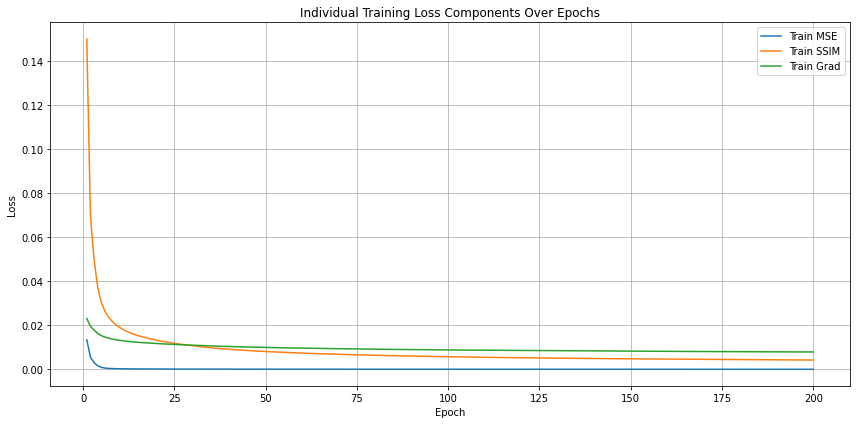

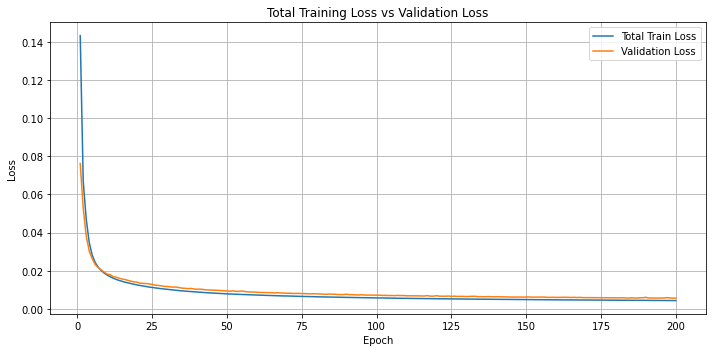

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

file_path = "checkpoints/loss_details.txt"  # Update the path if needed
data = pd.read_csv(file_path, sep='\t')

plt.figure(figsize=(12, 6))
plt.plot(data['Epoch'], data['Train_MSE'], label='Train MSE')
plt.plot(data['Epoch'], data['Train_SSIM'], label='Train SSIM')
plt.plot(data['Epoch'], data['Train_Grad'], label='Train Grad')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Individual Training Loss Components Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("checkpoints/individual_losses_curve.png")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(data['Epoch'], data['Total_Train_Loss'], label='Total Train Loss')
plt.plot(data['Epoch'], data['Val_Loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Total Training Loss vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("checkpoints/train_val_loss_curve.png")
plt.show()
